In [72]:
print('hello world')

hello world


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Activation,BatchNormalization, Input, Embedding , Dot , Dense , Flatten 
from tensorflow.keras.callbacks import ModelCheckpoint , LearningRateScheduler , TensorBoard , EarlyStopping 

from wordcloud import WordCloud 
%matplotlib inline 

# READING ANIMELIST.CSV

In [2]:
import os 


In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory = True , usecols = ['user_id' , 'anime_id' , 'rating'])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

# Data Processing

In [7]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings>=400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])


In [10]:
print(min_rating)
print(max_rating)
print(avg_rating)

0
10
4.122732695114736


In [11]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [12]:
rating_df.duplicated().sum()

np.int64(0)

In [13]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [14]:
user_ids = rating_df['user_id'].unique().tolist()

user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}

## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [15]:
n_users = len(user2user_encoded)

In [16]:
n_users

4203

In [17]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {x : i for i , x in enumerate(anime_ids)}

rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [18]:
n_anime = len(anime2anime_encoded)

In [19]:
n_anime

17149

In [20]:
rating_df = rating_df.sample(frac=1 , random_state=43).reset_index(drop = True)

In [21]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [22]:
X = rating_df[['user' , 'anime']].values
y = rating_df['rating']


In [23]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size


In [24]:
X_train , X_test , y_train , y_test = (
    X[:train_indices], 
    X[train_indices:], 
    y[:train_indices], 
    y[train_indices:]
)

In [25]:
len(X_train)

3245641

In [26]:
X_train

array([[ 120, 1377],
       [1195, 1216],
       [1591, 1239],
       ...,
       [ 368,  861],
       [2198, 2402],
       [  81, 1262]])

In [27]:
X_train[: , 0]

array([ 120, 1195, 1591, ...,  368, 2198,   81])

In [28]:
X_train[: , 1]

array([1377, 1216, 1239, ...,  861, 2402, 1262])

In [29]:
X_train_array = [X_train[: , 0] , X_train[: , 1]]
X_test_array = [X_test[: , 0] , X_test[: , 1]]

In [30]:
type(X_test_array)

list

In [31]:
type(X_test_array[0])

numpy.ndarray

# Model Architecture

In [32]:
def RecommenderNet():
    embedding_size = 128
    
    user = Input(name = "user" , shape=[1])
    user_embedding = Embedding(name="user_embedding" , input_dim = n_users , output_dim = embedding_size)(user)
    
    anime = Input(name = "anime" , shape=[1])
    anime_embedding = Embedding(name="anime_embedding" , input_dim = n_anime , output_dim = embedding_size)(anime)
    
    x = Dot(name = "dot_product" , normalize=True , axes=2)([user_embedding, anime_embedding])
    
    x = Flatten()(x)
    
    x = Dense(1 , kernel_initializer='he_normal')(x)
    x= BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy' , metrics=['mae' , 'mse'] , optimizer= 'Adam')
    
    return model


# This RecommenderNet model: ✅ Uses embedding layers to learn hidden user-anime relationships.
# ✅ Computes dot product similarity between users and animes.
# ✅ Uses batch normalization and a dense layer to refine predictions.
# ✅ Outputs a probability score (0 to 1) indicating how much a user might like an anime.

# 🔹 Potential Improvements

# Instead of binary_crossentropy, use mean_squared_error (MSE) if predicting explicit ratings (e.g., 1-10).

# Consider using additional metadata (e.g., genre, popularity) for better recommendations.
    

In [33]:
model = RecommenderNet()


In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [35]:
# This code is for scheduling learning parameters 

start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs*epoch + start_lr
    elif epoch<rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    

In [36]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose = 0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only = True , monitor='val_loss' , mode='min' , save_best_only = True)

early_stopping = EarlyStopping(patience=3 , monitor= "val_loss" , mode="min" , restore_best_weights = True)

In [37]:
my_callbacks = [model_checkpoint , lr_callback , early_stopping]

In [38]:
history = model.fit(
    x= X_train_array , 
    y = y_train ,
    batch_size = batch_size , 
    epochs = 20 ,
    verbose = 1 , 
    validation_data = (X_test_array , y_test) , 
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 0.7776 - mae: 0.3782 - mse: 0.1900 - val_loss: 0.7011 - val_mae: 0.3619 - val_mse: 0.1596 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 0.7745 - mae: 0.3769 - mse: 0.1886 - val_loss: 0.7533 - val_mae: 0.3720 - val_mse: 0.1815 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.7691 - mae: 0.3749 - mse: 0.1864 - val_loss: 0.7720 - val_mae: 0.3755 - val_mse: 0.1881 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.7612 - mae: 0.3717 - mse: 0.1831 - val_loss: 0.7690 - val_mae: 0.3748 - val_mse: 0.1869 - learning_rate: 3.4000e-05


In [39]:
model.load_weights(checkpoint_filepath)

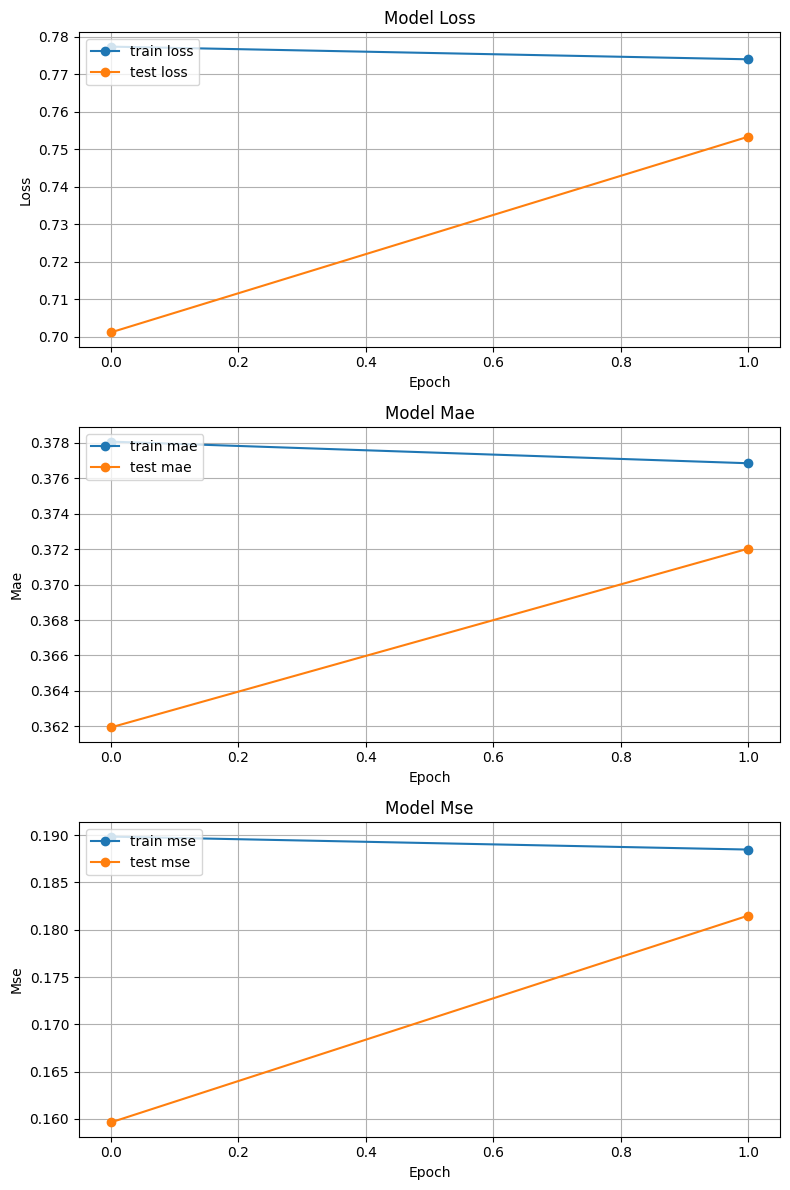

In [40]:
metrics = ['loss' , 'mae' , 'mse']

fig , axes = plt.subplots(len(metrics) , 1 , figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker= 'o' , label = f"train {metric}")
    ax.plot(history.history[f'val_{metric}'][0:-2], marker = "o" , label=f'test {metric}')
    ax.set_title(f'Model {metric.capitalize()}')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [41]:
def extract_weights(name , model):
    weight_layer = model.get_layer(name)
    print(weight_layer)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis = 1).reshape((-1,1))
    return weights

In [42]:
anime_weights = extract_weights('anime_embedding' , model)

<Embedding name=anime_embedding, built=True>


In [43]:
user_weights = extract_weights("user_embedding" , model)

<Embedding name=user_embedding, built=True>


# Reading Anime.csv

In [44]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [45]:
df = df.replace('Unknown', np.nan)

In [46]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('Error')
    return name 

In [47]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x:getAnimeName(x))


In [48]:
getAnimeName(6702)

'Fairy Tail'

In [49]:
df.sort_values(by = ['Score'] , inplace=True , ascending= False , kind= 'quicksort' , na_position='last')

In [50]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [51]:
df = df[['anime_id' , 'eng_version' , 'Score' , 'Genres' , 'Episodes' , 'Type' , 'Premiered' , 'Members']]

In [52]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [53]:
def getAnimeFrame(anime , df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [54]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [55]:
getAnimeFrame('Gintama Season 4' , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


# Anime_With_Synopsis.csv

In [56]:
cols = ['MAL_ID' , "Name" , "Genres" , "sypnopsis"]

In [57]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)


In [58]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [59]:
def getSynopsis(anime , synopsis_df):
    if isinstance(anime , int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime , str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [60]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

# Content Based Recommendation

In [61]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights
    dists = np.dot(weights, weights[encoded_index])
    sorted_dists = np.argsort(dists)

    n = n + 1
    closest = sorted_dists[:n] if neg else sorted_dists[-n:]

    if return_dist:
        return dists, closest

    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)

        if decoded_id is None:
            # print(f"Warning: No decoded ID found for index {close}")
            continue

        anime_frame = getAnimeFrame(decoded_id, df)

        if anime_frame.empty:
            print(f"Warning: No anime found for decoded_id {decoded_id}")
            continue

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })

    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [62]:
find_similar_animes(
    "Naruto",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
2,Koutetsu Sangokushi,1.000000,"Adventure, Historical, Shounen"
1,Thumbelina:A Magical Story,0.287037,"Adventure, Fantasy, Shoujo"
0,Emergency Departure Rescue Kids,0.284898,"Action, Sci-Fi, Adventure, Comedy, Mecha"


# User Based Recommendation 

In [63]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded , n=10 , return_dist = False , neg=False):
    try:
        index = item_input 
        encoded_index = user2user_encoded.get(index)
        weights = user_weights 
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n+1
        
        if neg: 
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)
                    

In [64]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,1773,0.306655
8,15941,0.302862
7,9399,0.285881
6,4312,0.267917
5,6101,0.259092
4,9484,0.258564
3,9660,0.255231
2,4011,0.252708
1,11292,0.247524
0,10235,0.237299


In [65]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width = 700 , height=400 , background_color='white' , colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud , interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [66]:
from collections import defaultdict

In [67]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [68]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [69]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [70]:
def get_user_preferences(user_id , rating_df , df , plot=False):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    
    top_animes_user = (
        animes_watched_by_user.sort_values(by='rating' , ascending= False).anime_id.values 
    )
    
    anime_df_rows = df[df['anime_id'].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[['eng_version' , 'Genres']]
    
    if plot:
        getFavGenre(anime_df_rows , plot)
    
    return anime_df_rows

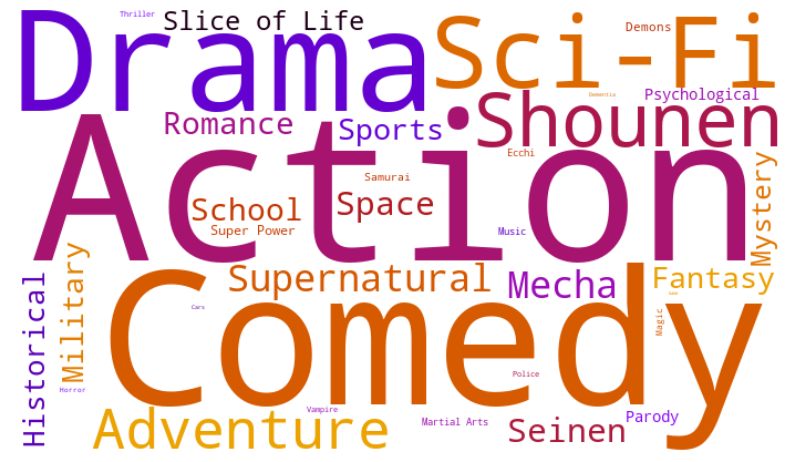

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [71]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [81]:
def get_user_recommendations(similar_users , user_pref , df , synopsis_df , rating_df , n=10):
    
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df , df)
        
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values) 
    
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    #   print(sorted_list.index)   
        
                #     Index(['Attack on Titan', 'Death Note', 'Attack on Titan Season 2',
                #    'Nisekoi:False Love', 'My Teen Romantic Comedy SNAFU TOO!'],
                #   dtype='object')
        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            
            if isinstance(anime_name , str):
                frame = getAnimeFrame(anime_name , df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)
                
                recommended_animes.append({
                    'n': n_user_pref,
                    'anime_name': anime_name , 
                    'Genres'  : genre , 
                    'Synopsis': synopsis
                })
    return pd.DataFrame(recommended_animes).head(n)       

In [73]:
similar_users = find_similar_users(int(11880) , user_weights , user2user_encoded , user2user_decoded)

In [74]:
user_pref = get_user_preferences(11880 , rating_df , df , plot= False)

In [82]:
get_user_recommendations(similar_users , user_pref , df , synopsis_df , rating_df , n=5)

,n,anime_name,Genres,Synopsis
0,8,Attack on Titan,"Action, Military, Mystery, Super Power, Drama,...","Centuries ago, mankind was slaughtered to near..."
1,8,Death Note,"Mystery, Police, Psychological, Supernatural, ...","shinigami, as a god of death, can kill any per..."
2,7,Attack on Titan Season 2,"Action, Military, Mystery, Super Power, Drama,...","For centuries, humanity has been hunted by gia..."
3,7,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari H..."
4,7,My Teen Romantic Comedy SNAFU TOO!,"Slice of Life, Comedy, Drama, Romance, School",Yahari Ore no Seishun Love Comedy wa Machigatt...


# Hybrid Recommender System 

In [86]:
def hybrid_recommendation(user_id , user_weight=0.5 , content_weight = 0.5):
    
    # User Recommendation 
    
    similar_users = find_similar_users(user_id , user_weights , user2user_encoded , user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df , df)
    user_recommended_animes =  get_user_recommendations(similar_users , user_pref , df , synopsis_df, rating_df)
    
    user_recommended_anime_list = user_recommended_animes['anime_name'].tolist()
    print(user_recommended_anime_list)
    
    # Content Recommendation 
    
    content_recommended_animes = []
    
    for anime in user_recommended_anime_list :
        similar_animes = find_similar_animes(anime , anime_weights, anime2anime_encoded, anime2anime_decoded , df , synopsis_df)
        
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes['name'].tolist())
        
        else:
            print(f'No Similar anime found {anime}')
    
    combined_scores = {}
    
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime , 0) + user_weight
        print(combined_scores.get(anime , 0))

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime , 0) + content_weight
    
    sorted_animes = sorted(combined_scores.items() , key= lambda x:x[1] , reverse = True)
    
    return [anime for anime , score in sorted_animes[:10]]
    
    
    
    

In [87]:
hybrid_recommendation(11880)

['Attack on Titan', 'Death Note', 'Attack on Titan Season 2', 'Nisekoi:False Love', 'My Teen Romantic Comedy SNAFU TOO!', 'Toradora!', 'My Teen Romantic Comedy SNAFU', 'Mob Psycho 100', "KonoSuba:God's Blessing on This Wonderful World! 2", 'Code Geass:Lelouch of the Rebellion']


KeyError: 'similarity'

In [88]:
hybrid_recommendation(13994)

['Bakuman.', 'GATE', 'Digimon:The Movie', 'OreImo', 'Maid Sama!', 'Clannad', 'My Little Monster', 'Deadman Wonderland', 'Dragon Ball Z', 'The Familiar of Zero:Knight of the Twin Moons']


KeyError: 'similarity'